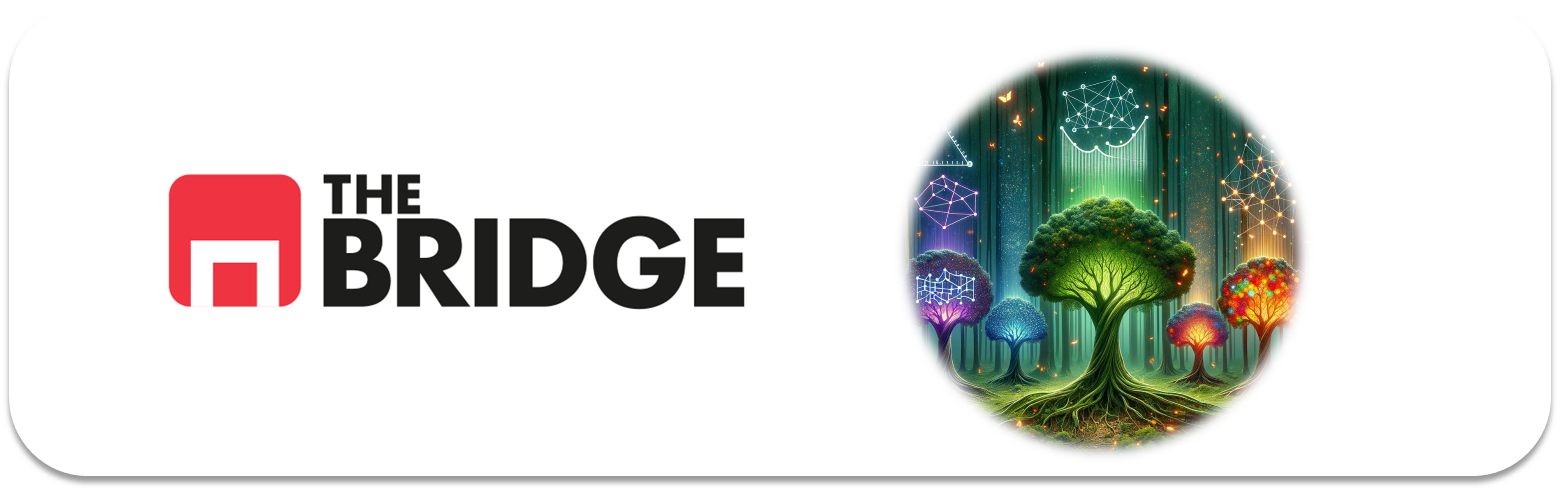

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [325]:
import numpy as np
import pandas as pd


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

In [326]:
df = pd.read_csv('./data/bank-full.csv', sep=';')

In [327]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [328]:
def card_tipo(df,umbral_categoria = 10, umbral_continua = 30):
    # Primera parte: Preparo el dataset con cardinalidades, % variación cardinalidad, y tipos
    df_temp = pd.DataFrame([df.nunique(), df.nunique()/len(df) * 100, df.dtypes]) # Cardinaliad y porcentaje de variación de cardinalidad
    df_temp = df_temp.T # Como nos da los valores de las columnas en columnas, y quiero que estas sean filas, la traspongo
    df_temp = df_temp.rename(columns = {0: "Card", 1: "%_Card", 2: "Tipo"}) # Cambio el nombre de la transposición anterior para que tengan más sentido, y uso asignación en vez de inplace = True (esto es arbitrario para el tamaño de este dataset)

    # Corrección para cuando solo tengo un valor
    df_temp.loc[df_temp.Card == 1, "%_Card"] = 0.00

    # Creo la columna de sugerenica de tipo de variable, empiezo considerando todas categóricas pero podría haber empezado por cualquiera, siempre que adapte los filtros siguientes de forma correspondiente
    df_temp["tipo_sugerido"] = "Categorica"
    df_temp.loc[df_temp["Card"] == 2, "tipo_sugerido"] = "Binaria"
    df_temp.loc[df_temp["Card"] >= umbral_categoria, "tipo_sugerido"] = "Numerica discreta"
    df_temp.loc[df_temp["%_Card"] >= umbral_continua, "tipo_sugerido"] = "Numerica continua"
    # Ojo los filtros aplicados cumplen con el enunciado pero no siguen su orden y planteamiento

    return df_temp

In [329]:
card_tipo(df, 13)

,Card,%_Card,Tipo,tipo_sugerido
age,77,0.170313,int64,Numerica discreta
job,12,0.026542,object,Categorica
marital,3,0.006636,object,Categorica
education,4,0.008847,object,Categorica
default,2,0.004424,object,Binaria
balance,7168,15.854549,int64,Numerica discreta
housing,2,0.004424,object,Binaria
loan,2,0.004424,object,Binaria
contact,3,0.006636,object,Categorica
day,31,0.068567,int64,Numerica discreta


In [330]:
target = 'y'

In [331]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
df[target] = ordinal_encoder.fit_transform(df[[target]])

In [332]:
from sklearn.model_selection import train_test_split 

# X = df.drop([target], axis=1)
# y = df[target]

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

<Axes: xlabel='y', ylabel='count'>

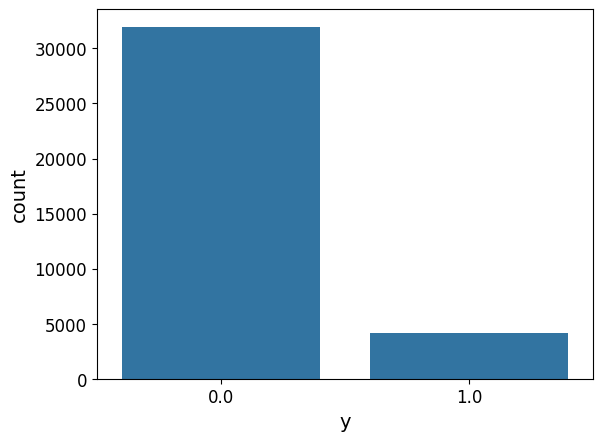

In [333]:
import seaborn as sns
sns.barplot(data=pd.DataFrame(train_set[target].value_counts()), x=target, y='count')

In [334]:
numericas = card_tipo(df, 13)['tipo_sugerido'] == 'Numerica discreta'
features_num = card_tipo(df, 13)[numericas].index.to_list()
features_cat = card_tipo(df, 13)[:-1][~numericas].index.to_list()

C:\Users\Eva\AppData\Local\Temp\ipykernel_16204\2090323158.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  features_cat = card_tipo(df, 13)[:-1][~numericas].index.to_list()


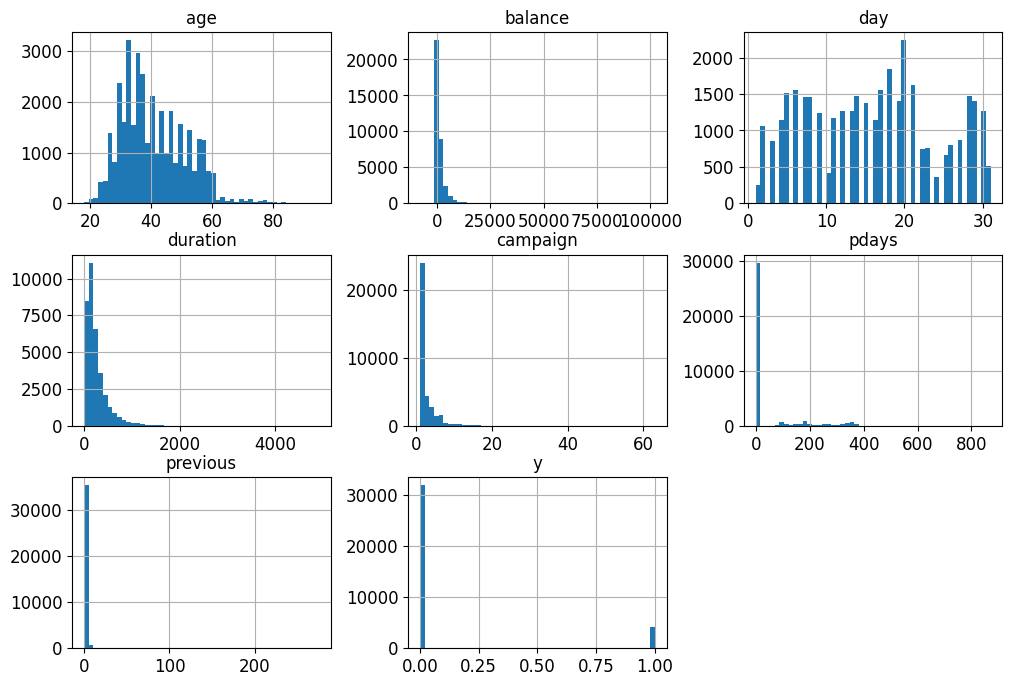

In [335]:
df_eda = train_set.copy()
df_eda.hist(bins=50, figsize=(12, 8)) # La forma de generar histogramas de una sola vez para las variables numéricas de un dataset
plt.show()

In [336]:
df_eda['previous_cat'] = df_eda['previous'].apply(lambda x: 0 if x == 0 else 1)

In [337]:
features_num.append('previous_cat')

In [338]:
features_num

['age',
 'balance',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'previous_cat']

In [339]:
df_eda.rename(columns={'y': 'target'}, inplace=True)

In [340]:
df_eda

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,target,previous_cat
3344,41,blue-collar,married,primary,no,849,yes,no,unknown,15,may,72,1,-1,0,unknown,0.0,0
17965,49,technician,married,primary,no,1415,yes,no,cellular,30,jul,269,2,-1,0,unknown,0.0,0
18299,42,admin.,married,secondary,no,3842,no,no,cellular,31,jul,130,4,-1,0,unknown,0.0,0
10221,37,management,single,tertiary,no,-119,yes,no,unknown,11,jun,375,11,-1,0,unknown,0.0,0
32192,56,blue-collar,married,primary,no,3498,no,no,cellular,15,apr,264,2,-1,0,unknown,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,44,housemaid,single,primary,no,1059,no,no,unknown,18,jun,2093,1,-1,0,unknown,1.0,0
44732,23,student,single,tertiary,no,508,no,no,cellular,8,sep,210,1,92,1,failure,0.0,1
38158,34,technician,divorced,tertiary,no,1317,yes,no,cellular,15,may,239,1,-1,0,unknown,0.0,0
860,33,retired,married,secondary,no,165,no,no,unknown,7,may,111,1,-1,0,unknown,0.0,0


In [341]:
np.abs(df_eda[['age',
 'balance',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'previous_cat', 
 'target']].corr()['target']).sort_values(ascending=False)

target          1.000000
duration        0.393402
previous_cat    0.169852
pdays           0.105742
previous        0.092051
campaign        0.072571
balance         0.052518
age             0.026684
day             0.025887
Name: target, dtype: float64

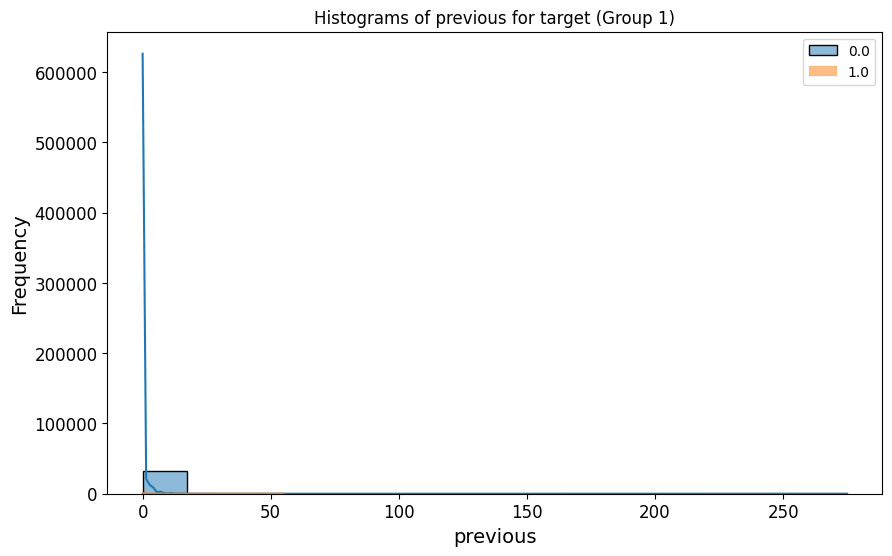

In [342]:
from bootcampviztools import *
plot_grouped_histograms(df_eda, cat_col='target', num_col='previous', group_size=2)

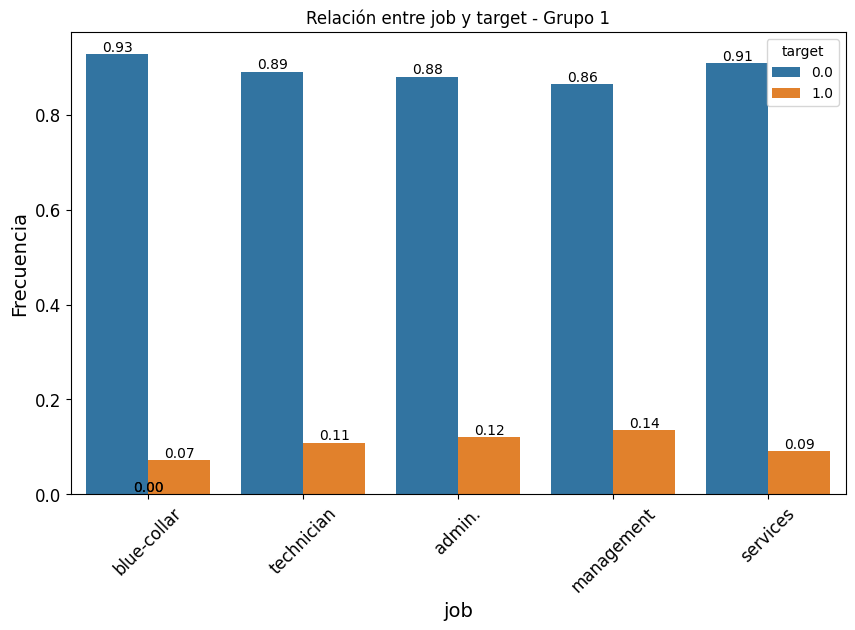

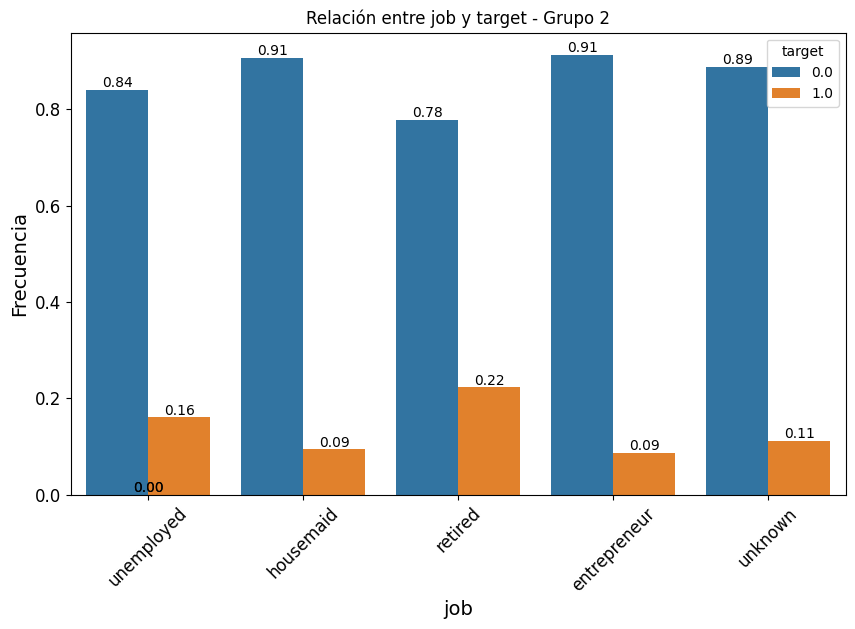

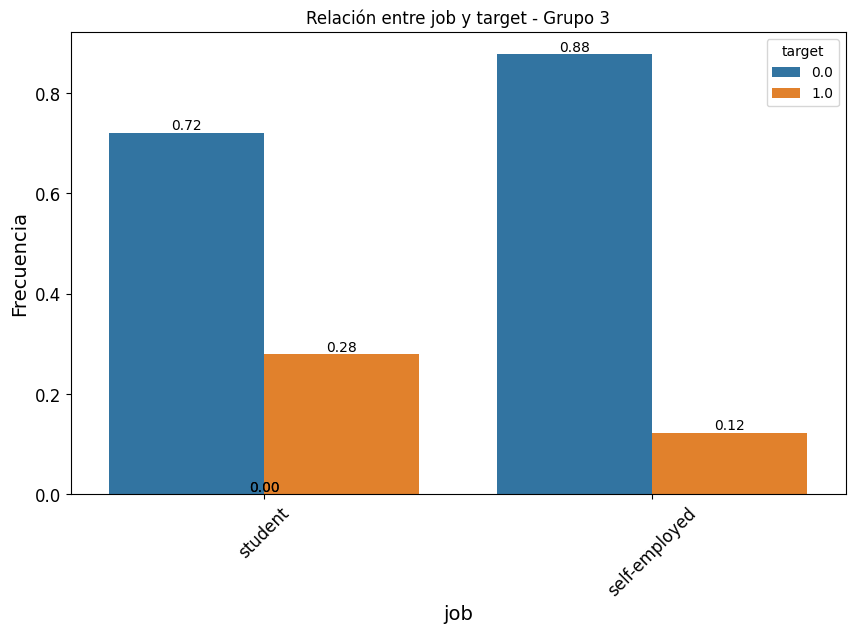

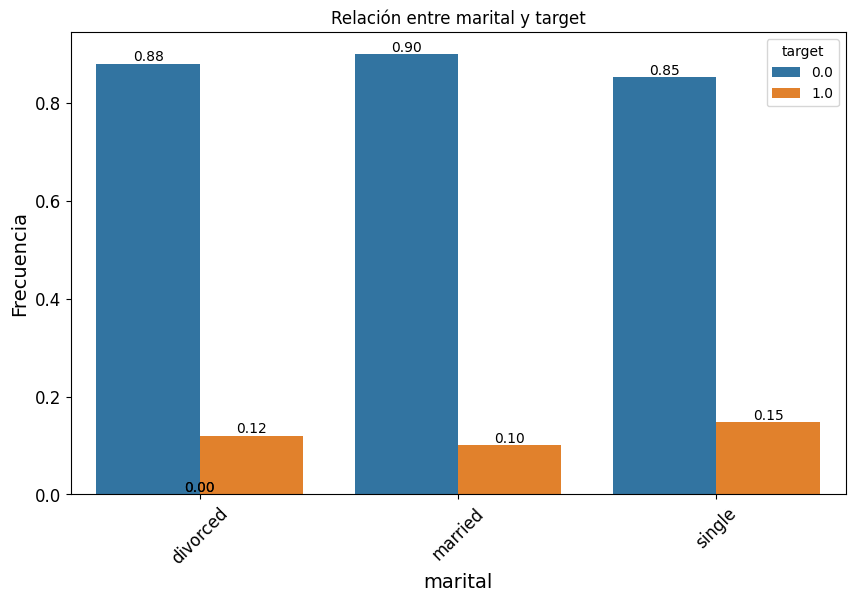

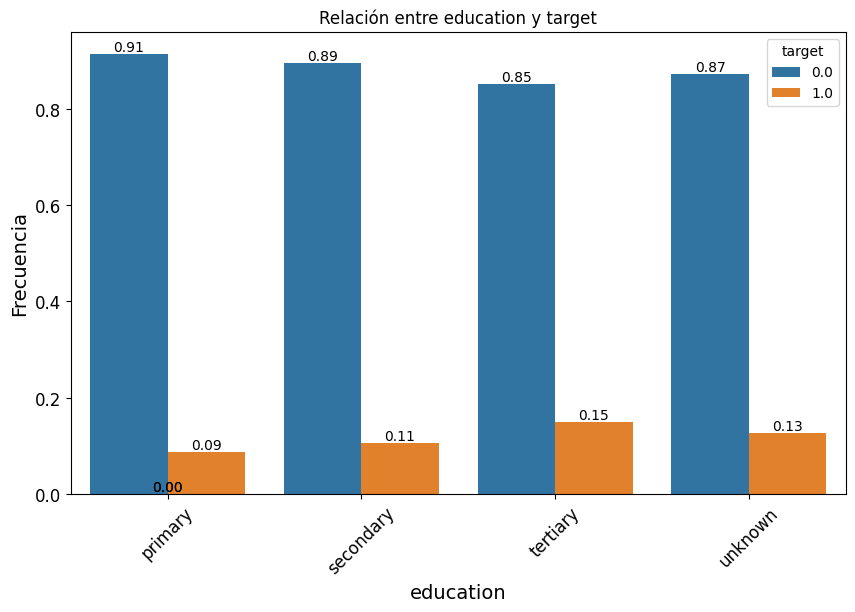

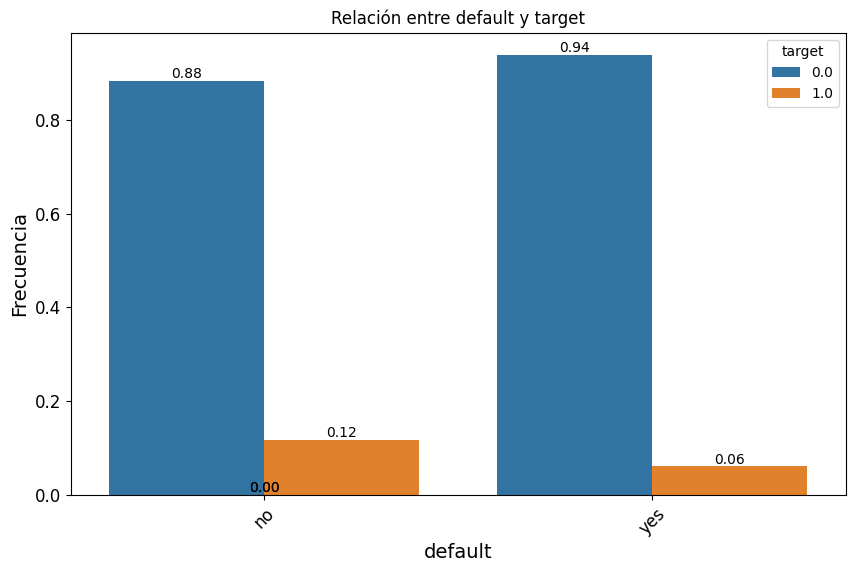

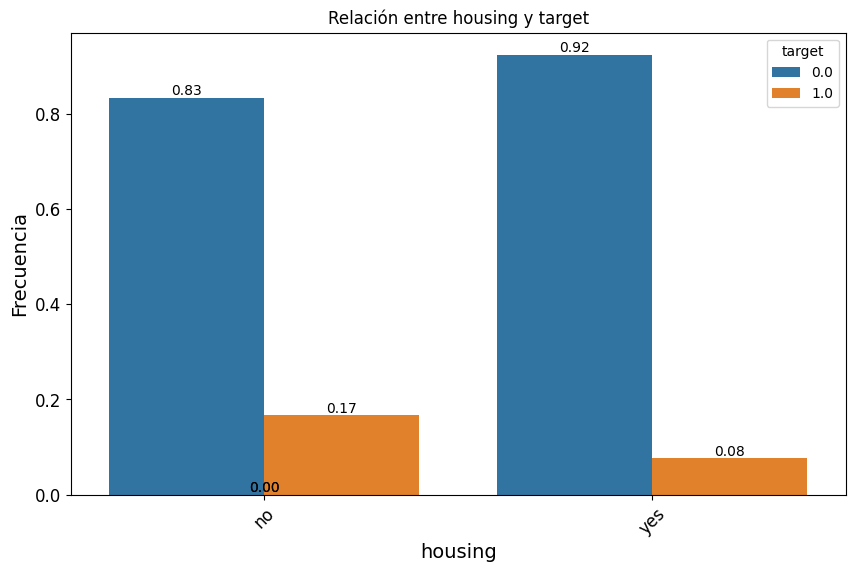

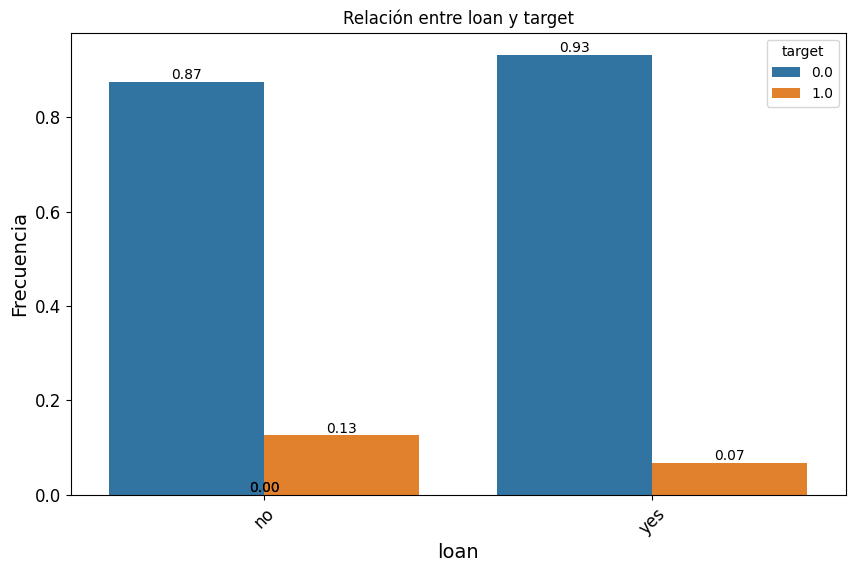

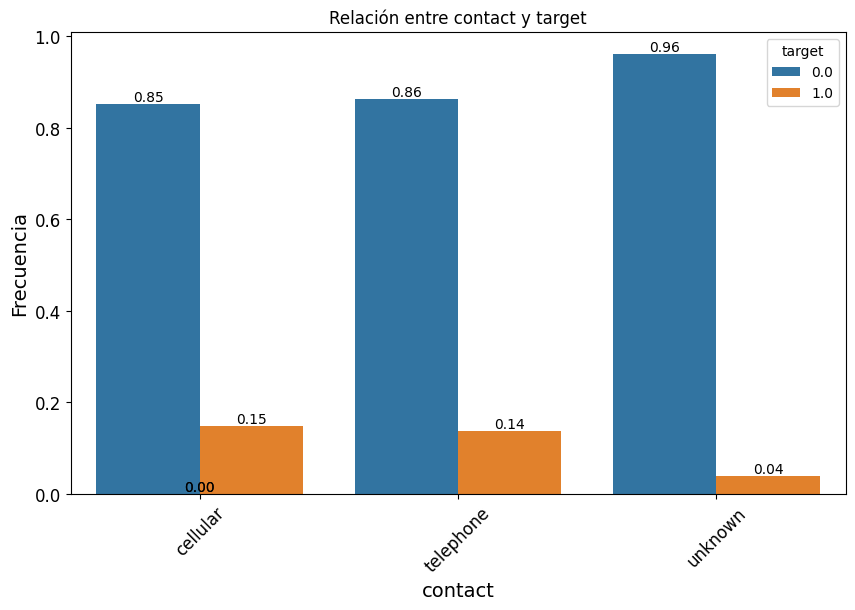

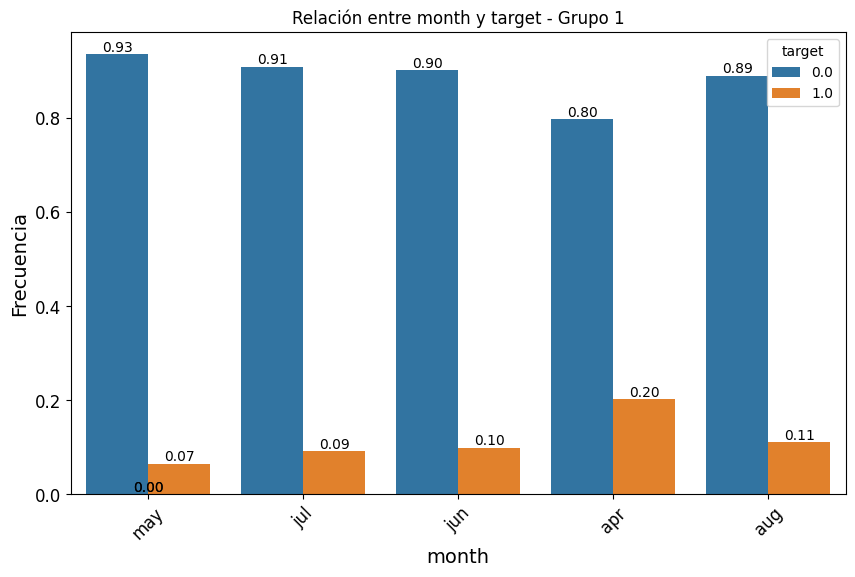

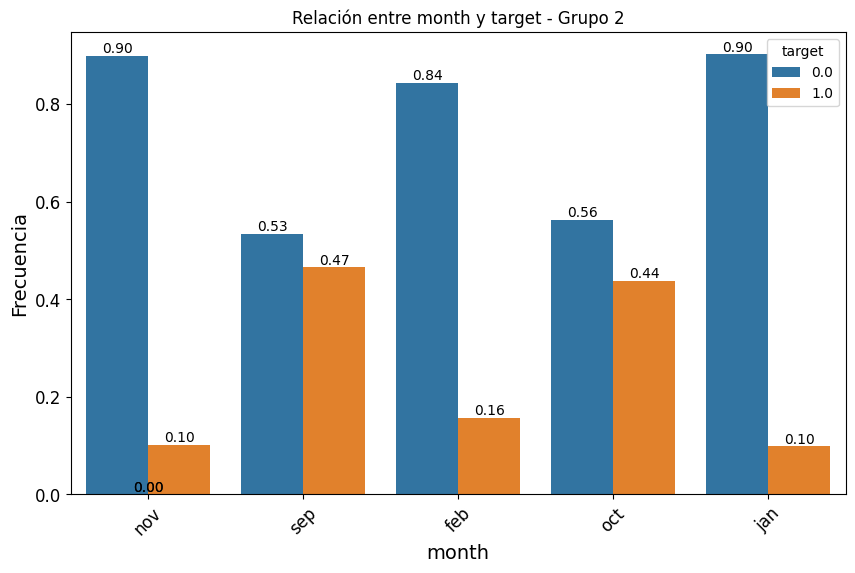

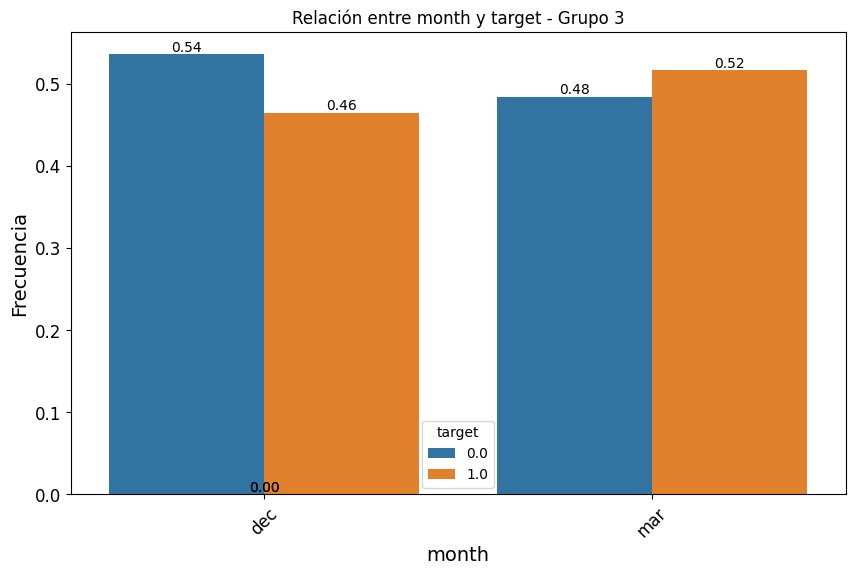

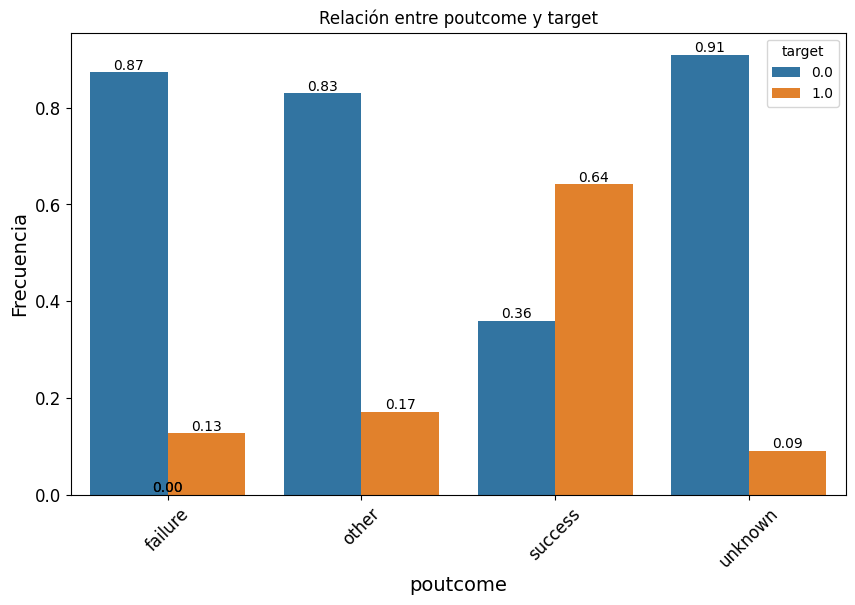

In [343]:

for col in features_cat:
    plot_categorical_relationship_fin(df_eda, col, 'target', relative_freq=True, show_values=True)

In [344]:
# Ordinal encoding con meses
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
categories = [['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug','sep', 'oct','nov','dec']]
ordinal_encoder = OrdinalEncoder(categories= categories)
df_eda["ordinal_month"] = ordinal_encoder.fit_transform(df_eda[["month"]])

In [345]:
df_eda[['month',"ordinal_month"]].sort_values('ordinal_month')

,month,ordinal_month
27831,jan,0.0
27931,jan,0.0
28351,jan,0.0
28244,jan,0.0
28580,jan,0.0
...,...,...
42391,dec,11.0
42515,dec,11.0
42415,dec,11.0
42426,dec,11.0


In [346]:
features_cat_encoded = ['ordinal_month']

In [347]:
# Ordinal encoding con education
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
categories = [[ 'unknown', 'primary', 'secondary', 'tertiary']]
ordinal_encoder = OrdinalEncoder(categories= categories)
df_eda["ordinal_education"] = ordinal_encoder.fit_transform(df_eda[["education"]])

In [348]:
df_eda.education.unique()

array(['primary', 'secondary', 'tertiary', 'unknown'], dtype=object)

In [349]:
features_cat_encoded.append('ordinal_education')

In [350]:
# Ordinal encoding con las binarias Default, Housing y loan
ordinal_encoder = OrdinalEncoder()
df_eda['default'] = ordinal_encoder.fit_transform(df_eda[['default']])
df_eda['housing'] = ordinal_encoder.fit_transform(df_eda[['housing']])
df_eda['loan'] = ordinal_encoder.fit_transform(df_eda[['loan']])

In [351]:
features_cat_encoded.append('default')
features_cat_encoded.append('housing')
features_cat_encoded.append('loan')

In [352]:
features_cat_encoded

['ordinal_month', 'ordinal_education', 'default', 'housing', 'loan']

In [353]:
categories = [['unknown', 'cellular', 'telephone']]
ordinal_encoder = OrdinalEncoder(categories= categories)
df_eda["ordinal_contact"] = ordinal_encoder.fit_transform(df_eda[["contact"]])
features_cat_encoded.append('ordinal_contact')

In [354]:
ordinal_encoder = OrdinalEncoder()
categories = [['unknown', 'failure', 'other', 'success']]
ordinal_encoder = OrdinalEncoder(categories= categories)
df_eda["ordinal_poutcome"] = ordinal_encoder.fit_transform(df_eda[["poutcome"]])
features_cat_encoded.append('ordinal_poutcome')

In [355]:
# One-hot encoding con job
train_set_bck = df_eda.copy()
df_eda = pd.get_dummies(df_eda, columns=["job"], dtype= int)

In [356]:
df_eda.columns

Index(['age', 'marital', 'education', 'default', 'balance', 'housing', 'loan',
       'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'target', 'previous_cat', 'ordinal_month',
       'ordinal_education', 'ordinal_contact', 'ordinal_poutcome',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown'],
      dtype='object')

In [357]:
features_cat_encoded

['ordinal_month',
 'ordinal_education',
 'default',
 'housing',
 'loan',
 'ordinal_contact',
 'ordinal_poutcome']

In [358]:
np.abs(df_eda[['ordinal_month',
 'ordinal_education',
 'default',
 'housing',
 'loan',
 'ordinal_contact',
 'ordinal_poutcome',
 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 
 'target']].corr()['target']).sort_values(ascending=False)

target               1.000000
ordinal_poutcome     0.260405
housing              0.140234
ordinal_contact      0.134126
job_retired          0.076440
job_student          0.073606
job_blue-collar      0.071767
loan                 0.066708
ordinal_education    0.052848
job_management       0.030974
job_services         0.025259
ordinal_month        0.024388
default              0.023934
job_unemployed       0.023566
job_entrepreneur     0.016888
job_housemaid        0.011729
job_technician       0.010275
job_admin.           0.004291
job_self-employed    0.004072
job_unknown          0.001127
Name: target, dtype: float64

In [359]:
features_num

['age',
 'balance',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'previous_cat']

In [360]:
np.abs(df_eda[['age',
 'balance',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'previous_cat', 'ordinal_month',
 'ordinal_education',
 'default',
 'housing',
 'loan',
 'ordinal_contact',
 'ordinal_poutcome',
 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 
 'target']].corr()['target']).sort_values(ascending=False)

target               1.000000
duration             0.393402
ordinal_poutcome     0.260405
previous_cat         0.169852
housing              0.140234
ordinal_contact      0.134126
pdays                0.105742
previous             0.092051
job_retired          0.076440
job_student          0.073606
campaign             0.072571
job_blue-collar      0.071767
loan                 0.066708
ordinal_education    0.052848
balance              0.052518
job_management       0.030974
age                  0.026684
day                  0.025887
job_services         0.025259
ordinal_month        0.024388
default              0.023934
job_unemployed       0.023566
job_entrepreneur     0.016888
job_housemaid        0.011729
job_technician       0.010275
job_admin.           0.004291
job_self-employed    0.004072
job_unknown          0.001127
Name: target, dtype: float64

In [361]:
# Alternativa ordinal encoding
train_set_bck_2 = df_eda.copy()
ordinal_encoder = OrdinalEncoder()
train_set_bck["ordinal_job"] = ordinal_encoder.fit_transform(train_set_bck[["job"]])

In [362]:
np.abs(train_set_bck[['age',
 'balance',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'previous_cat', 'ordinal_month',
 'ordinal_education',
 'default',
 'housing',
 'loan',
 'ordinal_contact',
 'ordinal_poutcome',
 'ordinal_job', 
 'target']].corr()['target']).sort_values(ascending=False)

target               1.000000
duration             0.393402
ordinal_poutcome     0.260405
previous_cat         0.169852
housing              0.140234
ordinal_contact      0.134126
pdays                0.105742
previous             0.092051
campaign             0.072571
loan                 0.066708
ordinal_education    0.052848
balance              0.052518
ordinal_job          0.040499
age                  0.026684
day                  0.025887
ordinal_month        0.024388
default              0.023934
Name: target, dtype: float64

In [363]:
train_set_bck.corr(numeric_only=True)

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,target,previous_cat,ordinal_month,ordinal_education,ordinal_contact,ordinal_poutcome,ordinal_job
age,1.000000,-0.017948,0.098921,-0.184809,-0.014826,-0.007882,-0.007414,0.003160,-0.023231,0.002397,0.026684,0.001680,0.088299,-0.173359,0.088578,0.012925,-0.026214
default,-0.017948,1.000000,-0.068618,-0.004473,0.078079,0.010791,-0.011930,0.016127,-0.031854,-0.017628,-0.023934,-0.041045,0.018394,-0.005319,-0.018212,-0.039354,-0.003290
balance,0.098921,-0.068618,1.000000,-0.067396,-0.086546,0.000455,0.025590,-0.018566,0.002122,0.015291,0.052518,0.027023,0.093294,0.048120,0.045475,0.035974,0.019176
housing,-0.184809,-0.004473,-0.067396,1.000000,0.044123,-0.030083,0.002413,-0.022054,0.124121,0.037643,-0.140234,0.064518,-0.173256,-0.039794,-0.203995,0.001801,-0.126429
loan,-0.014826,0.078079,-0.086546,0.044123,1.000000,0.019523,-0.013425,0.013598,-0.022544,-0.010680,-0.066708,-0.029699,0.023545,0.003937,0.000861,-0.046182,-0.034608
day,-0.007882,0.010791,0.000455,-0.030083,0.019523,1.000000,-0.025719,0.160599,-0.094405,-0.053229,-0.025887,-0.089174,0.101935,0.023983,0.043701,-0.076990,0.023051
duration,-0.007414,-0.011930,0.025590,0.002413,-0.013425,-0.025719,1.000000,-0.086526,-0.001179,0.002557,0.393402,0.004193,-0.010336,0.003533,0.003996,0.023443,0.006488
campaign,0.003160,0.016127,-0.018566,-0.022054,0.013598,0.160599,-0.086526,1.000000,-0.089317,-0.033300,-0.072571,-0.108223,0.055669,-0.001136,0.021056,-0.095446,0.005507
pdays,-0.023231,-0.031854,0.002122,0.124121,-0.022544,-0.094405,-0.001179,-0.089317,1.000000,0.440662,0.105742,0.869726,-0.109040,0.007686,0.211567,0.709398,-0.025771
previous,0.002397,-0.017628,0.015291,0.037643,-0.010680,-0.053229,0.002557,-0.033300,0.440662,1.000000,0.092051,0.517509,-0.034784,0.024235,0.135223,0.472229,0.000664


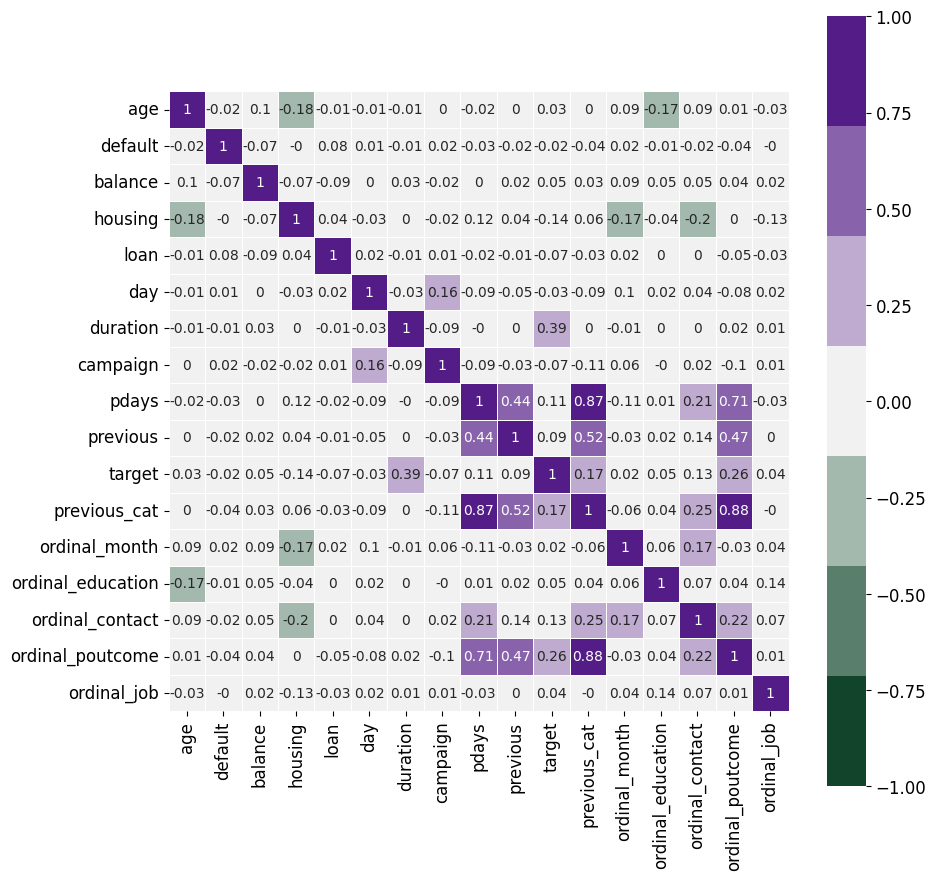

In [364]:
plt.figure(figsize=(10,10))
sns.heatmap(np.round(train_set_bck.corr(numeric_only=True), 2),
            vmin=-1,
            vmax=1,
            annot=True,
            cmap=sns.diverging_palette(145, 280, s=85, l=25, n=7),
            square=True,
            linewidths=.5);

In [365]:
features = ['age',
 'balance',
 'duration',
 'campaign',
 'pdays',
 'previous_cat',
 'ordinal_education',
 'default',
 'housing',
 'loan',
 'ordinal_contact',
 'ordinal_poutcome',
 'ordinal_job']

In [366]:
train_set_def = train_set_bck[features]

In [367]:
y_train = train_set_bck['target']

In [368]:
# Cambios sobre el test_set
test_set_bck = test_set.copy()
test_set_bck

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
3776,40,blue-collar,married,secondary,no,580,yes,no,unknown,16,may,192,1,-1,0,unknown,0.0
9928,47,services,single,secondary,no,3644,no,no,unknown,9,jun,83,2,-1,0,unknown,0.0
33409,25,student,single,tertiary,no,538,yes,no,cellular,20,apr,226,1,-1,0,unknown,0.0
31885,42,management,married,tertiary,no,1773,no,no,cellular,9,apr,311,1,336,1,failure,0.0
15738,56,management,married,tertiary,no,217,no,yes,cellular,21,jul,121,2,-1,0,unknown,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13353,47,management,married,tertiary,no,1890,no,no,cellular,8,jul,161,1,-1,0,unknown,0.0
38732,32,blue-collar,single,secondary,no,217,yes,no,cellular,15,may,692,3,-1,0,unknown,1.0
5654,52,admin.,divorced,secondary,no,0,yes,no,unknown,26,may,206,1,-1,0,unknown,0.0
3779,40,admin.,divorced,secondary,no,783,yes,yes,unknown,16,may,171,2,-1,0,unknown,0.0


In [369]:
test_set['previous_cat'] = test_set['previous'].apply(lambda x: 0 if x == 0 else 1)
ordinal_encoder = OrdinalEncoder()

test_set['default'] = ordinal_encoder.fit_transform(test_set[['default']])
test_set['housing'] = ordinal_encoder.fit_transform(test_set[['housing']])
test_set['loan'] = ordinal_encoder.fit_transform(test_set[['loan']])

categories = [['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug','sep', 'oct','nov','dec']]
ordinal_encoder = OrdinalEncoder(categories= categories)
test_set["ordinal_month"] = ordinal_encoder.fit_transform(test_set[["month"]])

ordinal_encoder = OrdinalEncoder()
categories = [[ 'unknown', 'primary', 'secondary', 'tertiary']]
ordinal_encoder = OrdinalEncoder(categories= categories)
test_set["ordinal_education"] = ordinal_encoder.fit_transform(test_set[["education"]])

ordinal_encoder = OrdinalEncoder()
categories = [['unknown', 'cellular', 'telephone']]
ordinal_encoder = OrdinalEncoder(categories= categories)
test_set["ordinal_contact"] = ordinal_encoder.fit_transform(test_set[["contact"]])

ordinal_encoder = OrdinalEncoder()
categories = [['unknown', 'failure', 'other', 'success']]
ordinal_encoder = OrdinalEncoder(categories= categories)
test_set["ordinal_poutcome"] = ordinal_encoder.fit_transform(test_set[["poutcome"]])

ordinal_encoder = OrdinalEncoder()
test_set["ordinal_job"] = ordinal_encoder.fit_transform(test_set[["job"]])

In [370]:
y_test = test_set[target]
test_set = test_set[features]

In [371]:
features

['age',
 'balance',
 'duration',
 'campaign',
 'pdays',
 'previous_cat',
 'ordinal_education',
 'default',
 'housing',
 'loan',
 'ordinal_contact',
 'ordinal_poutcome',
 'ordinal_job']

(13, 2)


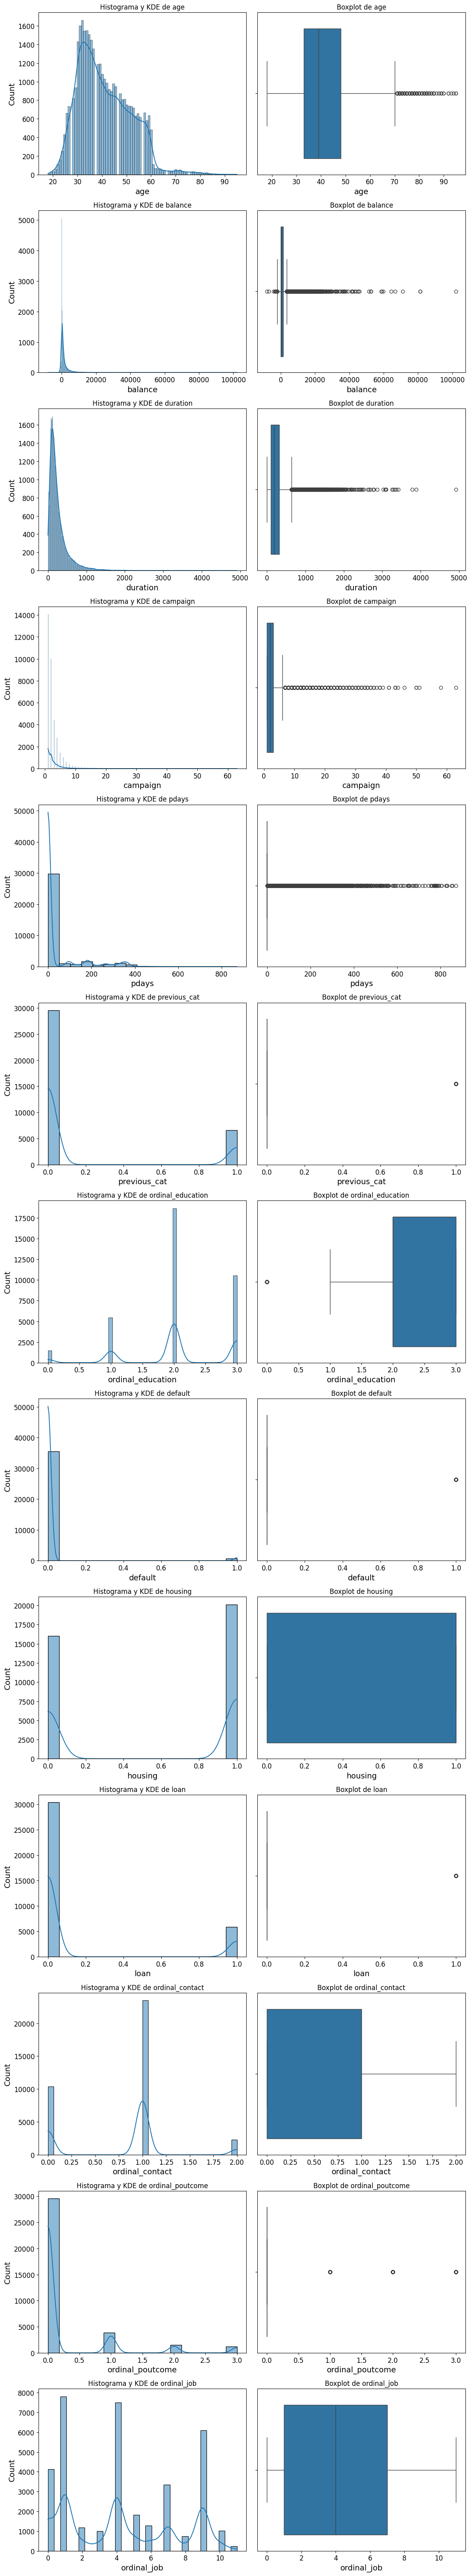

In [372]:
plot_combined_graphs(train_set_def, features)

In [373]:
features

['age',
 'balance',
 'duration',
 'campaign',
 'pdays',
 'previous_cat',
 'ordinal_education',
 'default',
 'housing',
 'loan',
 'ordinal_contact',
 'ordinal_poutcome',
 'ordinal_job']

In [374]:
# aplicamos la logarítmica a todas
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

train_set_def["balance"] = np.log1p(train_set_def["balance"] - train_set_def["balance"] + 1)
train_set_def["duration"] = np.log1p(train_set_def["duration"] - train_set_def["duration"] + 1)
train_set_def["campaign"] = np.log1p(train_set_def["campaign"] - train_set_def["campaign"] + 1)


C:\Users\Eva\AppData\Local\Temp\ipykernel_16204\536165007.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_def["balance"] = np.log1p(train_set_def["balance"] - train_set_def["balance"] + 1)
C:\Users\Eva\AppData\Local\Temp\ipykernel_16204\536165007.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_def["duration"] = np.log1p(train_set_def["duration"] - train_set_def["duration"] + 1)
C:\Users\Eva\AppData\Local\Temp\ipykernel_16204\536165007.py:7: SettingWithCopyWarning: 
A value is try

In [384]:
test_set["balance"] = np.log1p(test_set["balance"] - test_set["balance"] + 1)
test_set["duration"] = np.log1p(test_set["duration"] - test_set["duration"] + 1)
test_set["campaign"] = np.log1p(test_set["campaign"] - test_set["campaign"] + 1)

In [375]:
train_set_def.columns

Index(['age', 'balance', 'duration', 'campaign', 'pdays', 'previous_cat',
       'ordinal_education', 'default', 'housing', 'loan', 'ordinal_contact',
       'ordinal_poutcome', 'ordinal_job'],
      dtype='object')

In [379]:
col_scaler = ['age', 'balance', 'duration', 'campaign', 'pdays']

In [383]:
for col in col_scaler:
    train_set_def[col] = std_scaler.fit_transform(train_set_def[[col]])

C:\Users\Eva\AppData\Local\Temp\ipykernel_16204\717942605.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_def[col] = std_scaler.fit_transform(train_set_def[[col]])
C:\Users\Eva\AppData\Local\Temp\ipykernel_16204\717942605.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_def[col] = std_scaler.fit_transform(train_set_def[[col]])
C:\Users\Eva\AppData\Local\Temp\ipykernel_16204\717942605.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [385]:
for col in col_scaler:
    test_set[col] = std_scaler.fit_transform(test_set[[col]])

In [392]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import ElasticNet
param_grid = {
    'alpha': [0.001, 1, 5, 10, 20, 40, 80, 150],
    'l1_ratio': np.arange(0,1,0.01)
}

elastic = ElasticNet()

random_search = RandomizedSearchCV(elastic, # El modelo que quiero entrenar
                                   param_grid, # El grid de parámetros
                                   random_state=1, # Semilla
                                   n_iter=100, # Nº de iteraciones del random search
                                   cv=5, # Folds del cross validation
                                   scoring="neg_root_mean_squared_error", # Métrica que quiero optimizar
                                   n_jobs = -1 # Paralelizar
                                  )

random_search.fit(train_set_def, y_train)

RandomizedSearchCV(cv=5, estimator=ElasticNet(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [0.001, 1, 5, 10, 20, 40, 80,
                                                  150],
                                        'l1_ratio': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])},
                   random_state=1, scoring='neg_root_mean_squared_error')

In [397]:
random_search.best_params_

{'l1_ratio': np.float64(0.03), 'alpha': 0.001}

In [398]:
from sklearn.metrics import mean_squared_error

model = ElasticNet(alpha=0.0001, l1_ratio=0.03)
model.fit(train_set_def, y_train)
print(model.score(train_set_def,y_train))
print("RMSE_train", np.sqrt(mean_squared_error(y_train, model.predict(train_set_def))))
print(model.score(test_set, y_test))
print("RMSE_test", np.sqrt(mean_squared_error(y_test, model.predict(test_set))))

0.10734310492346211
RMSE_train 0.3026288469871218
0.10304839976623359
RMSE_test 0.3084768195958288


In [ ]:
# comparación contra baseline
from sklearn.linear_model import LinearRegression

reg_model = LinearRegression()
reg_model.fit(train_set_def, y_train)
print(reg_model.score(train_set_def,y_train))
print("RMSE", np.sqrt(mean_squared_error(y_train, reg_model.predict(train_set_def))))
print(reg_model.score(test_set, y_test))
print("RMSE", np.sqrt(mean_squared_error(y_test, reg_model.predict(test_set))))

0.1073435604820937
RMSE 0.3026287697652901
0.10306330030345223
RMSE 0.3084742573118549


In [404]:
# R2 mejora mediante el random search, pero no es demasiado mejor, ya que en sí el target es póbremente explicado por el modelo
0.10734310492346211 - 0.1073435604820937

-4.555586315957427e-07